In [ ]:
### Installations

%pip install pandas==1.1.5
%pip install numpy

In [ ]:
### Further Installations

%pip install pyLDAvis
%pip install pyLDAvis.gensim
%pip install bokeh
%pip install gensim
%pip install spacy
%pip install logging
%pip install wordcloud
%pip install nltk
%pip install -U pip setuptools wheel
%pip install -U spacy
%pip install -U seaborn
%pip install translators

In [ ]:
!{sys.executable} -m spacy download en_core_web_sm

In [1]:
### Imports
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import sys
import re
import numpy as np
import requests
import xml
import xml.etree.ElementTree as ET 
import logging, warnings
import spacy, gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from requests.utils import requote_uri
from requests.utils import requote_uri
from pprint import pprint


In [ ]:
### Words to remove:

STOP_WORDS_CONSTANTS = ["get", "amp"]

In [2]:
def splice(doc):
    counts = 'numChars numCharsMinusSpacesAndPunctuation numWords numSentences numPunctuation'
    speech = 'numNouns nounRatio numVerbs verbRatio numAdjectives adjectiveRatio numAdverbs adverbRatio'
    immediacy = 'numPassiveVerbs passiveVerbRatio'
    pronouns = 'firstPersonSingular firstPersonSingularRatio firstPersonPlural firstPersonPluralRatio secondPerson secondPersonRatio thirdPersonSingular thirdPersonSingularRatio thirdPersonPlural thirdPersonPluralRatio'
    positive_self = 'iCanDoIt doKnow posSelfImage'
    negative_self = 'iCantDoIt dontKnow negSelfImage'
    influence = 'numImperatives suggestionPhrases inflexibility contradict totalDominance dominanceRatio numAgreement agreementRatio'
    deference = "askPermission seekGuidance totalSubmissiveness submissivenessRatio"
    affect = "Imagery Pleasantness Activation"
    complexity = "avgWordLength avgSentenceLength numSyllables avgSyllablesPerWord numWordsWith3OrMoreSyllables rateWordsWith3OrMoreSyllables numWordsWith6OrMoreChars rateWordsWith6OrMoreChars numWordsWith7OrMoreChars rateWordsWith7OrMoreChars LexicalDiversity complexityComposite"
    style = "hedgeVerb hedgeConj hedgeAdj hedgeModal hedgeAll numDisfluencies disfluencyRatio numInterjections interjectionRatio numSpeculate speculateRatio Expressivity numIgnorance ignoranceRatio Pausality questionCount questionRatio hedgeUncertain"
    tense = 'pastTense pastTenseRatio presentTense presentTenseRatio'
    sentiment = "SWNpositivity SWNnegativity SWNobjectivity"
    readability = "ARI FRE FKGL CLI LWRF FOG SMOG DALE LIX RIX FRY"

    url = f"http://splice.cmi.arizona.edu/SPLICE/{doc}/{counts} {speech} {immediacy} {pronouns} {influence} {deference} {affect} {complexity} {style} {tense} {sentiment} {readability}"
    url_encoded = requote_uri(url)
    req = requests.request("GET", url_encoded)

    results = []
    root = ET.fromstring(req.text)
    for child in list(root.getchildren()):
        results.append(list([child.tag, child.text]))

    return results
      

In [3]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [4]:
def process_words(texts, stop_words_extend=[], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """Remove Stopwords, Form Bigrams, Trigrams and perform Lemmatization"""
  nltk.download('stopwords')
  stop_words = stopwords.words('english')
  stop_words.extend(['from', 'subject', 'co'])
  stop_words.extend(stop_words_extend)

  texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
  texts = [bigram_mod[doc] for doc in texts]
  texts = [trigram_mod[bigram_mod[doc]] for doc in texts]

  texts_out = []
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules

  for sent in texts:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

  # remove stopwords once more after lemmatization
  texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
  return texts_out


In [5]:
def latent_dirichlet(data, topics=4, print_output=False, random_state=0, chunk_size=100, passes=5):
    id2word = corpora.Dictionary(data)
    corpus = [id2word.doc2bow(text) for text in data_ready]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=topics, random_state=random_state, chunksize=chunk_size, passes=passes, per_word_topics=True)
    ldatopics = lda_model.show_topics(formatted=False)
    if print_output: pprint(lda_model.print_topics())
    return lda_model, ldatopics, id2word, corpus

def fit_lda (data, low=3, high=6, plot=False):
    fit = pd.DataFrame(columns=['topics', 'perplexity', 'coherence'])
    for n in range(low, high):
        lda_model, ldatopics, id2word, corpus = latent_dirichlet(data, n)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
        fit.loc[str(n-low)] = [n, round(lda_model.log_perplexity(corpus), 3), round(coherence_model_lda.get_coherence(), 3)]
    if plot:
        import seaborn as sns
        fit['diff'] = abs(fit.coherence - fit.perplexity)
        sns.lineplot(x='topics', y='diff', data=fit, ci=None, marker='o');
    return fit

def score_topics(df, lda_model, id2word):
    '''Returns scored DF. Pass in the DF used originally, the lda_model and the id2word from the lda function'''
    df_topics = df.copy()

    num_topics = len(lda_model.get_topics())
    for col in range(num_topics):
        df_topics[f'topic_{col + 1}'] = 0.0
        
    # Store the topic score and dominant topic
    for i, words in enumerate(data_ready):
        doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words
        
        for j, score in enumerate(doc[0]): # for each document in the corpus
        # Get the topic score and store it in the appropriate column
            df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]

    return df_topics

In [6]:
def topic_keywords(lda_model):
    from collections import Counter
    import matplotlib.colors as mcolors
    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in data_ready for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()


In [7]:
def cluster_topics(lda_model, corpus):
    from sklearn.manifold import TSNE
    from bokeh.plotting import figure, output_file, show
    from bokeh.models import Label
    from bokeh.io import output_notebook
    import matplotlib.colors as mcolors
    
    # Get topic weights
    topic_weights = []
    for i, row_list in enumerate(lda_model[corpus]):
        topic_weights.append([w for i, w in row_list[0]])
    
    # Array of topic weights    
    arr = pd.DataFrame(topic_weights).fillna(0).values
    
    # Keep the well separated points (optional)
    arr = arr[np.amax(arr, axis=1) > 0.35]
    
    # Dominant topic number in each doc
    topic_num = np.argmax(arr, axis=1)
    
    # tSNE Dimension Reduction
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
    tsne_lda = tsne_model.fit_transform(arr)
    
    # Plot the Topic Clusters using Bokeh
    output_notebook()
    n_topics = 4
    mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
    plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
                    plot_width=900, plot_height=700)
    plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
    show(plot)

In [8]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

df = pd.read_csv("noReplies.csv")
df.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


id     handle  followers  \
0  1221160812389203969  Applebees     599611   
1  1106316070821003265  Applebees     599611   
2  1106314060310679552  Applebees     599611   
3  1106311542570713089  Applebees     599611   
4  1106309275612311552  Applebees     599611   

                                                text lang  possibly_sensitive  \
0  Hurry in before the blue moon is gone. Not tha...   en               False   
1                                    cool me neither   en               False   
2  have you ever thought about how reading out lo...   en               False   
3             so did St. Patrick like...invent beer?   en               False   
4  Once I found a three-leaf clover, and then I g...   en               False   

   retweet_count  reply_count  like_count  quote_count  ... contains_quote  \
0              7           11          49            1  ...          False   
1             23            4          63            3  ...          False   
2              7            4          50            2  ...          False   
3             20            3          79            4  ...          False   
4              7            3          47            3  ...          False   

  is_reply num_referenced_tweets  url_image  num_hashtags  text_first_hashtag  \
0    False                     0        NaN             0                 NaN   
1    False                     0        NaN             0                 NaN   
2    False                     0        NaN             0                 NaN   
3    False                     0        NaN             0                 NaN   
4    False                     0        NaN             0                 NaN   

   num_mentions num_cashtags  num_polls interaction_score  
0             0            0          0          0.000101  
1             0            0          0          0.000194  
2             0            0          0          0.000097  
3             0            0          0          0.000198  
4             0            0          0          0.000099  

[5 rows x 24 columns]

In [9]:
def sentiment_scores(df):
    df_copy = df.copy()
    
    df_copy['sentiment_overall'] = 0.0
    df_copy['sentiment_neg'] = 0.0
    df_copy['sentiment_neu'] = 0.0
    df_copy['sentiment_pos'] = 0.0

    for row in df.itertuples():
        sentiment = sia.polarity_scores(row[5])
        df_copy.loc[row[0], 'sentiment_overall'] = sentiment['compound']
        df_copy.loc[row[0], 'sentiment_neg'] = sentiment['neg']
        df_copy.loc[row[0], 'sentiment_neu'] = sentiment['neu']
        df_copy.loc[row[0], 'sentiment_pos'] = sentiment['pos']
    return df_copy

In [10]:
data = df.text.values.tolist()
data_words = list(sent_to_words(data))

In [11]:
length = ''
for i in range(len(data_words)):
    for j in range(len(data_words[i])):
        length += data_words[i][j]
print(f'Corpus size: {str(len(length))}')

Corpus size: 8565252


In [12]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [13]:
data_ready = process_words(data_words)  # processed Text Data!
for tweet in data_ready[:5]:
    print(tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['hurry', 'blue_moon', 'go', 'brewtus', 'glass']
['cool']
['ever', 'think', 'read', 'loud', 'head', 'silent']
['st_patrick', 'invent', 'beer']
['find', 'leaf', 'clover', 'glue', 'leaf']


In [15]:
df = sentiment_scores(df)
lda_model, ldatopics, id2word, corpus = latent_dirichlet(data_ready, print_output=True)
df_scored = score_topics(df, lda_model, id2word)

[(0,
  '0.052*"order" + 0.051*"get" + 0.043*"free" + 0.026*"delivery" + 0.022*"amp" '
  '+ 0.017*"time" + 0.015*"well" + 0.014*"thank" + 0.011*"https" + '
  '0.011*"location"'),
 (1,
  '0.032*"fry" + 0.028*"burger" + 0.022*"make" + 0.021*"come" + 0.020*"try" + '
  '0.017*"take" + 0.015*"know" + 0.014*"want" + 0.014*"need" + 0.013*"flavor"'),
 (2,
  '0.026*"cheese" + 0.025*"available" + 0.021*"love" + 0.020*"see" + '
  '0.020*"chili" + 0.013*"bring" + 0.013*"shake" + 0.013*"look" + 0.012*"rt" + '
  '0.011*"win"'),
 (3,
  '0.040*"today" + 0.040*"day" + 0.031*"new" + 0.028*"get" + 0.026*"go" + '
  '0.025*"wing" + 0.018*"good" + 0.017*"celebrate" + 0.015*"say" + '
  '0.013*"year"')]


C:\Users\natha\AppData\Local\Temp/ipykernel_10472/3388736881.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


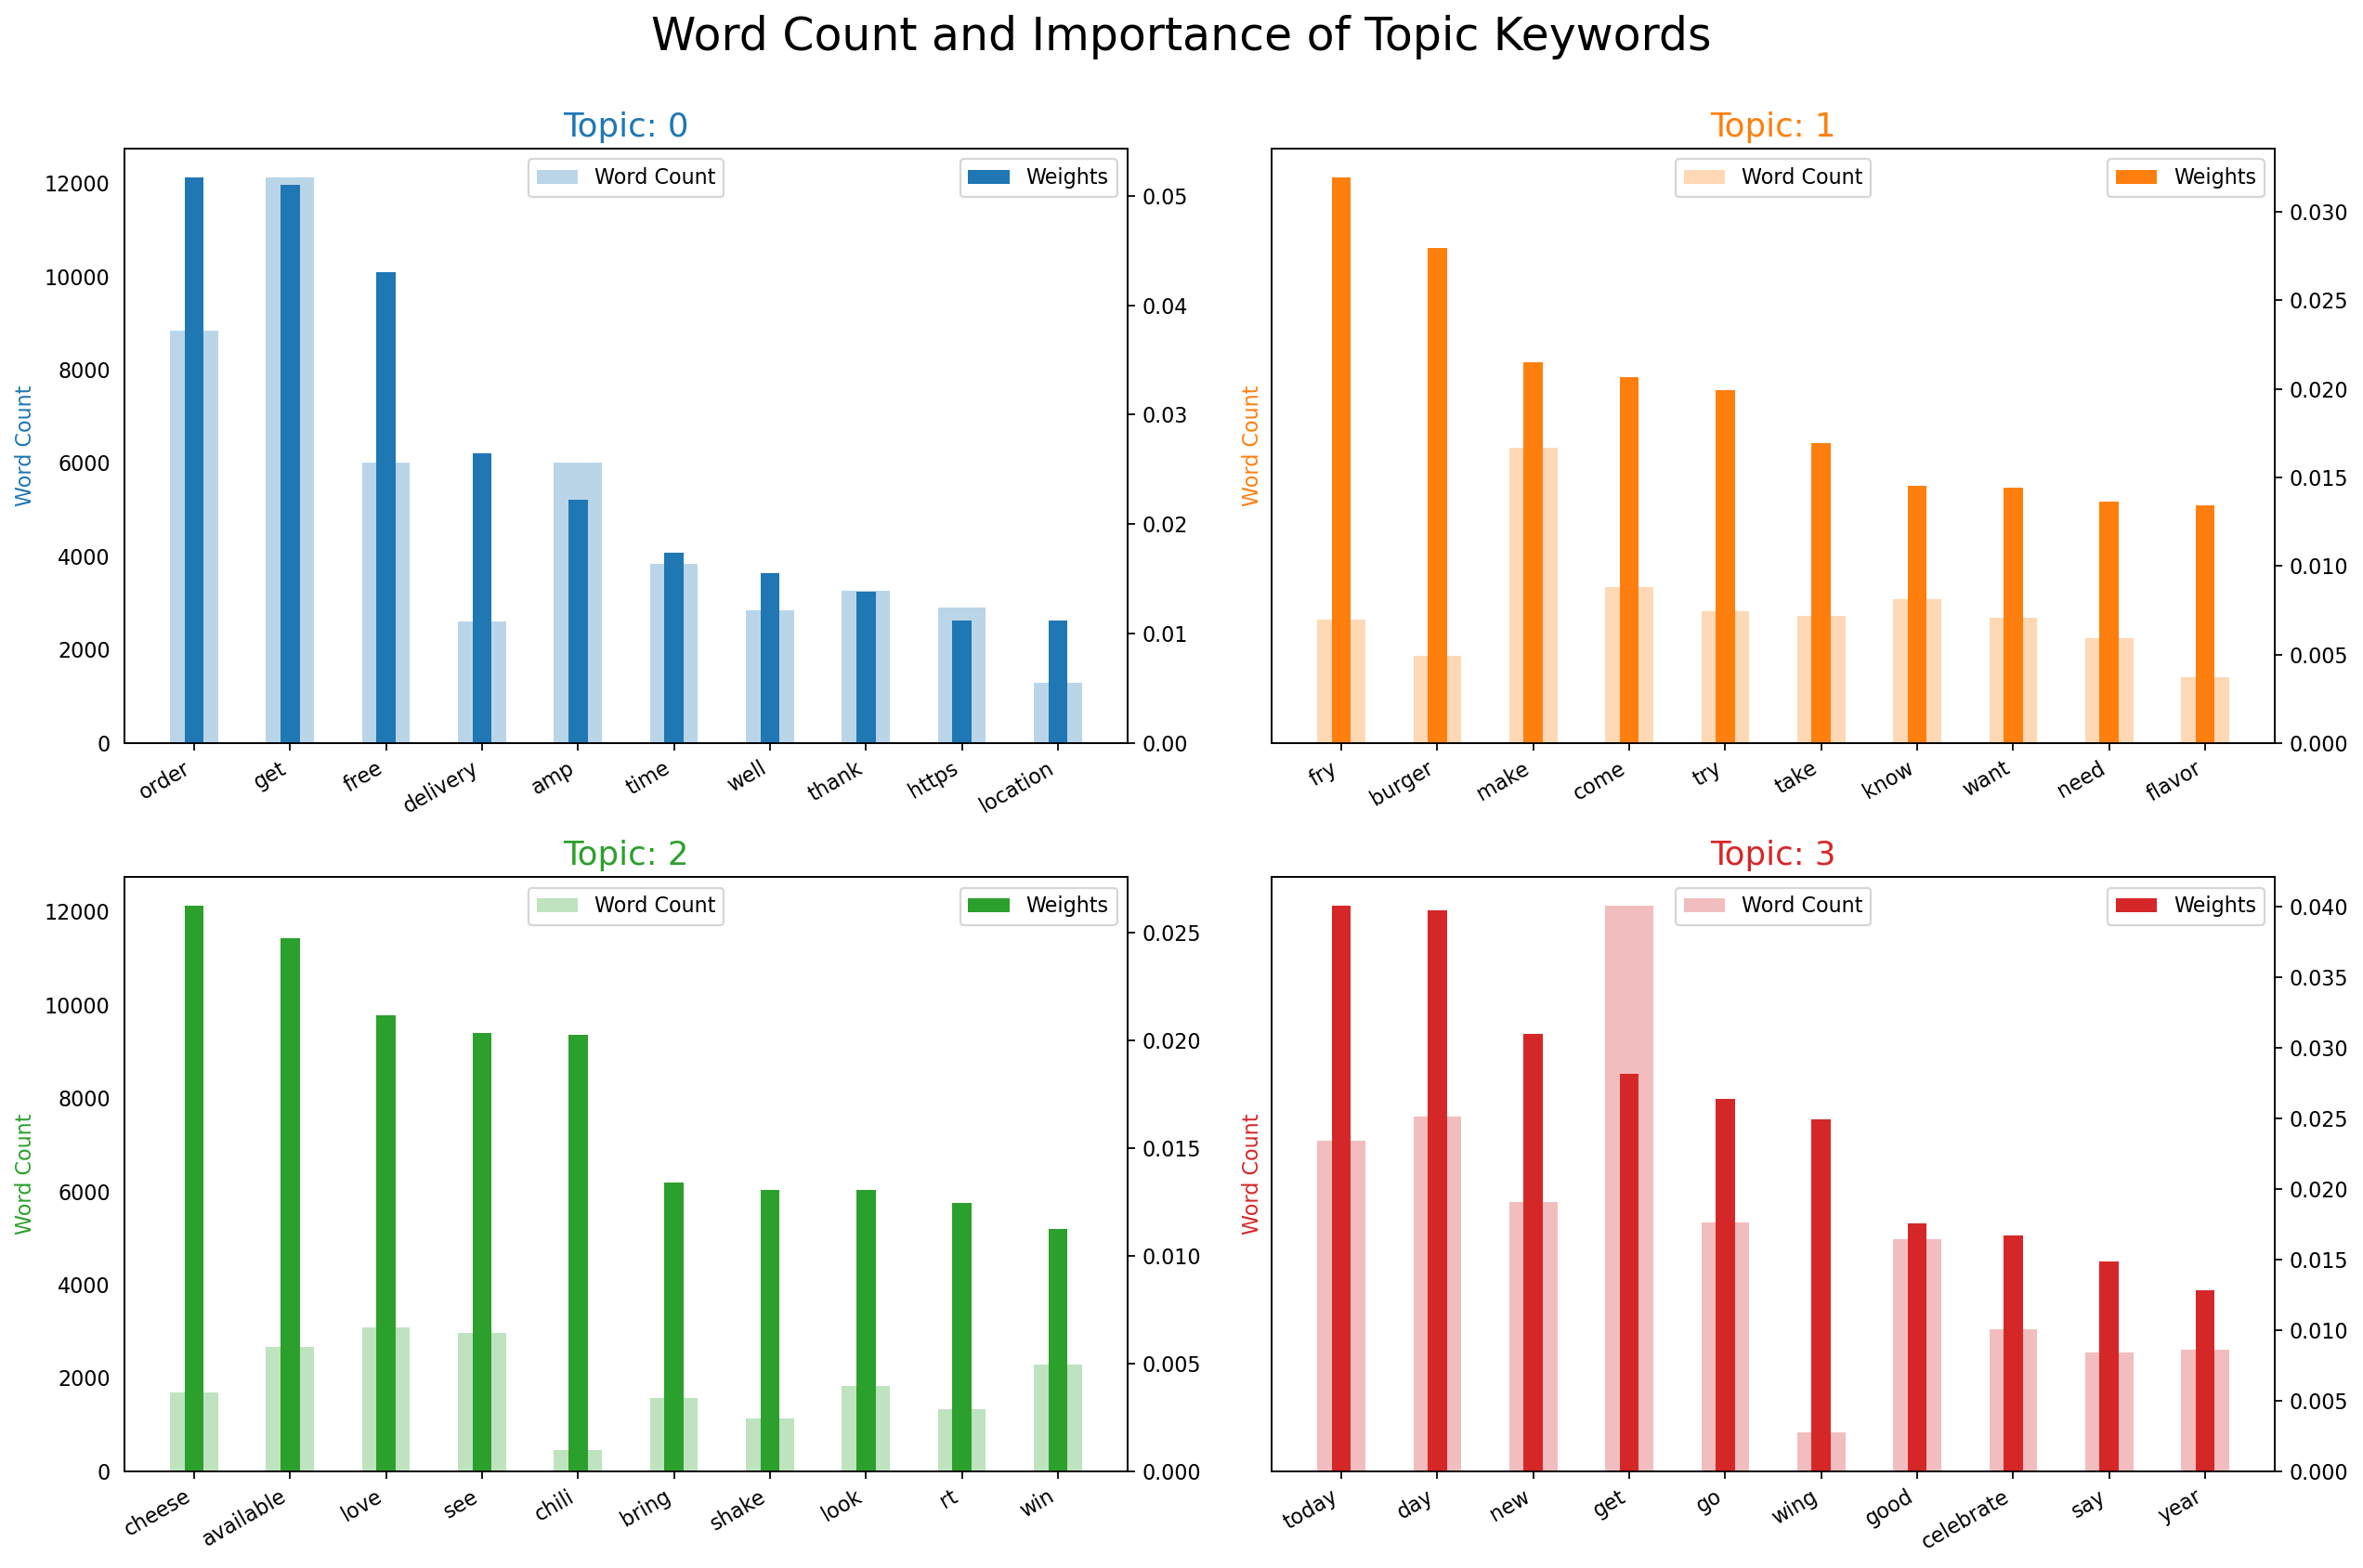

In [16]:
topic_keywords(lda_model)

In [17]:
cluster_topics(lda_model, corpus)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 85947 samples in 0.087s...
[t-SNE] Computed neighbors for 85947 samples in 2.351s...
[t-SNE] Computed conditional probabilities for sample 1000 / 85947
[t-SNE] Computed conditional probabilities for sample 2000 / 85947
[t-SNE] Computed conditional probabilities for sample 3000 / 85947
[t-SNE] Computed conditional probabilities for sample 4000 / 85947
[t-SNE] Computed conditional probabilities for sample 5000 / 85947
[t-SNE] Computed conditional probabilities for sample 6000 / 85947
[t-SNE] Computed conditional probabilities for sample 7000 / 85947
[t-SNE] Computed conditional probabilities for sample 8000 / 85947
[t-SNE] Computed conditional probabilities for sample 9000 / 85947
[t-SNE] Computed conditional probabilities for sample 10000 / 85947
[t-SNE] Computed conditional probabilities for sample 11000 / 85947
[t-SNE] Computed conditional probabilities for sample 12000 / 85947
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [19]:
df_scored.to_csv("noRepies-topics.csv")